In [327]:
import argparse
import logging
import time

import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.prototype.transforms import load_sp_model, PRETRAINED_SP_MODEL, SentencePieceTokenizer
from torchtext.utils import download_from_url
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import GloVe, FastText
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np
import random
from sentence_transformers import SentenceTransformer

In [328]:
# parser = argparse.ArgumentParser(description='finds the statiums')
# parser.add_argument('team', metavar='team', type=str, help='enter your team')
# args = parser.parse_args()
# team = args.team

In [329]:
# EXPERIMENT SETTING

# Dataset
DATASET = 'YelpReviewPolarity' # choose from 'AG_NEWS', 'AmazonReviewFull', 'DBpedia', 'IMDb', 'SogouNews', 'YahooAnswers', 'YelpReviewFull', 'YelpReviewPolarity'
# embedding method
EMBD = 'sbert' # choose from 'GloVe' or 'sbert'
# Corruption: if not then concatnate
INSERT = False 

## Dataset

In [330]:
if DATASET == 'AG_NEWS':
  train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
  NUM_CLASS = 4
elif DATASET == 'AmazonReviewFull':
  train_dataset, test_dataset  = torchtext.datasets.AmazonReviewFull()
  NUM_CLASS = 5
elif DATASET == 'DBpedia':
  train_dataset, test_dataset  = torchtext.datasets.DBpedia()
  NUM_CLASS = 14
elif DATASET == 'IMDb':
  train_dataset, test_dataset  = torchtext.datasets.IMDB()
  NUM_CLASS = 2
elif DATASET == 'SogouNews':
  train_dataset, test_dataset  = torchtext.datasets.SogouNews()
  NUM_CLASS = 5
elif DATASET == 'YahooAnswers':
  train_dataset, test_dataset  = torchtext.datasets.YahooAnswers()
  NUM_CLASS = 10
elif DATASET == 'YelpReviewFull':
  train_dataset, test_dataset  = torchtext.datasets.YelpReviewFull()
  NUM_CLASS = 5
elif DATASET == 'YelpReviewPolarity':
  train_dataset, test_dataset  = torchtext.datasets.YelpReviewPolarity()
  NUM_CLASS = 2

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [331]:
train_dataset = train_dataset[:1000]
test_dataset = test_dataset[:600]
print(len(train_dataset),len(test_dataset))

1000 600


## Embedding: GloVE/sbert

In [332]:
TOKENIZER = get_tokenizer("basic_english")

# GloVe
GLOVE = GloVe(name='840B', dim=300)
#([6, 300])
GLOVE.get_vecs_by_tokens(TOKENIZER("Hello, How are you?"), lower_case_backup=True) 


# FASTTEXT = FastText()

# sbert
model = SentenceTransformer('all-MiniLM-L6-v2')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']
embeddings = model.encode(sentences) #([3, 384])

In [333]:
if EMBD == 'sbert':
  model = SentenceTransformer('all-MiniLM-L6-v2')

  train_mapping = {}
  train_para = [_[1] for _ in train_dataset]
  train_embedd = torch.from_numpy(model.encode(train_para))

  train_mapping = dict(list(zip(train_para, train_embedd)))

  test_mapping = {}
  test_para = [_[1] for _ in test_dataset]
  test_embedd = torch.from_numpy(model.encode(test_para))

  test_mapping = dict(list(zip(test_para, test_embedd)))

  sbert_mapping = dict(train_mapping, **test_mapping)

In [334]:
len(sbert_mapping)

1600

# Forward-Forward Algo

## Dataset - get Positive Samples & Negative Samples

In [335]:
# define collate_fn with embedding method
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.cat([sbert_mapping[x].unsqueeze(0) for x in X], dim=0)

    return X_tensor, torch.tensor(Y) - 1 

In [336]:
num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# torch.Size([114000, embed]) torch.Size([114000])
train_loader = DataLoader(split_train_, batch_size=len(split_train_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([6000, embed]) torch.Size([6000])
valid_loader = DataLoader(split_valid_, batch_size=len(split_valid_), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

# torch.Size([7600, embed]) torch.Size([7600])
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [337]:
x_train, y = next(iter(train_loader))
x_train.shape, y.shape

(torch.Size([950, 384]), torch.Size([950]))

In [338]:
x_train[:5,:],y[:5]

(tensor([[ 0.0325,  0.0713,  0.0711,  ..., -0.0165, -0.0468,  0.0702],
         [ 0.0311,  0.0161,  0.0856,  ...,  0.1029, -0.1494,  0.0116],
         [ 0.0092,  0.0126, -0.0139,  ...,  0.0143, -0.0488,  0.0290],
         [-0.0739,  0.0200, -0.0231,  ..., -0.0232, -0.0131, -0.0016],
         [ 0.0054,  0.0064,  0.0771,  ..., -0.0159, -0.0317, -0.0174]]),
 tensor([0, 0, 1, 1, 0]))

In [339]:
def create_pos_neg(x_train, insert = True):
  
  x_pos = x_train.clone().detach()
  x_neg = x_train.clone().detach()

  # if concatenate
  if not insert:
    x_pos = torch.cat((torch.zeros(x_pos.size(0), NUM_CLASS), x_pos), 1)
    x_neg = torch.cat((torch.zeros(x_neg.size(0), NUM_CLASS), x_neg), 1)
  # if insert
  else:
    x_pos[:,0:NUM_CLASS] = torch.zeros(x_pos.size(0), NUM_CLASS)
    x_neg[:,0:NUM_CLASS] = torch.zeros(x_neg.size(0), NUM_CLASS)

  y_ = torch.randint(0,NUM_CLASS,(x_neg.size(0),))

  for i in range(x_neg.size(0)):
    x_pos[i,y[i]] = 1
    # x_neg[i,y_[i]] = 1
    # # NOTE: y_[i] maybe the right label, which will certainly hurt experiment results!
    if y_[i] != y[i]:
      x_neg[i,y_[i]] = 1
    else:
      x_neg[i,(y[i]+1)%NUM_CLASS] = 1
  
  return x_pos, x_neg

In [340]:
x_pos, x_neg = create_pos_neg(x_train, insert=INSERT)
embed_len = x_pos.shape[1]
embed_len

386

In [341]:
print(x_pos[:5,:])
print(x_neg[:5,:])

tensor([[ 1.0000,  0.0000,  0.0325,  ..., -0.0165, -0.0468,  0.0702],
        [ 1.0000,  0.0000,  0.0311,  ...,  0.1029, -0.1494,  0.0116],
        [ 0.0000,  1.0000,  0.0092,  ...,  0.0143, -0.0488,  0.0290],
        [ 0.0000,  1.0000, -0.0739,  ..., -0.0232, -0.0131, -0.0016],
        [ 1.0000,  0.0000,  0.0054,  ..., -0.0159, -0.0317, -0.0174]])
tensor([[ 0.0000,  1.0000,  0.0325,  ..., -0.0165, -0.0468,  0.0702],
        [ 0.0000,  1.0000,  0.0311,  ...,  0.1029, -0.1494,  0.0116],
        [ 1.0000,  0.0000,  0.0092,  ...,  0.0143, -0.0488,  0.0290],
        [ 1.0000,  0.0000, -0.0739,  ..., -0.0232, -0.0131, -0.0016],
        [ 0.0000,  1.0000,  0.0054,  ..., -0.0159, -0.0317, -0.0174]])


## Goodness Function

In [342]:
def goodness_power(X, p):
  return X.pow(p).mean(1)

def goodness_abs(X):
  return torch.abs(X).mean(1)

In [343]:
def goodness(X):
  return goodness_power(X,4.3)

## Model

In [344]:
layer_epoch = 1000
layer_threshold = 5  #2.0

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = layer_threshold
        self.num_epochs = layer_epoch
        self.loss_list = []

    def forward(self, x):
        x_direction = x / (x.norm(p = 2, dim = 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # torch.Size([114000, embed]) --> torch.Size([114000])
            g_pos = goodness(self.forward(x_pos))
            g_neg = goodness(self.forward(x_neg))
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.

            # after exp()  torch.Size([228000])
            # loss torch.size([1])
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()

            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
            self.loss_list.append(loss.detach().item())

            if i % 100 == 0 and i > 0:
              print(
                "| epoch {:3d} | loss {:8.3f}".format(i, loss)
              )
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [345]:
class Net(torch.nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
        # print(self.layers)

    def predict(self, x):
        goodness_per_label = []
        for label in range(NUM_CLASS):
            h = x.clone().detach()
            if INSERT:
              h[:, 0:NUM_CLASS] = torch.zeros(x.size(0), NUM_CLASS)
            else:
              h = torch.cat((torch.zeros(x.size(0), NUM_CLASS), h), dim = 1)
            h[:, label] = 1      
            # 4 , x.size(0)      
            goodnesses = []
            for layer in self.layers:
                h = layer(h)
                goodnesses += [goodness(h)]

            goodness_per_label += [sum(goodnesses).unsqueeze(1)]
        # [torch(x.size(0)),torch(x.size(0)),torch(x.size(0)),torch(x.size(0))]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        # print(goodness_per_label.shape)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        total_loss_list = []
        for i, layer in enumerate(self.layers):
            print("-" * 59)
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
            total_loss_list.append(layer.loss_list)
            print("-" * 59)
        return(total_loss_list)

## Train the model

In [346]:
net = Net([embed_len, 256, 128, 64, NUM_CLASS])
ls = net.train(x_pos, x_neg)

-----------------------------------------------------------
training layer 0 ...


 11%|█         | 111/1000 [00:01<00:13, 67.11it/s]

| epoch 100 | loss    0.043


 21%|██        | 208/1000 [00:03<00:13, 60.29it/s]

| epoch 200 | loss    0.009


 31%|███       | 308/1000 [00:04<00:10, 66.75it/s]

| epoch 300 | loss    0.006


 41%|████      | 410/1000 [00:06<00:08, 69.36it/s]

| epoch 400 | loss    0.005


 51%|█████     | 512/1000 [00:07<00:07, 69.38it/s]

| epoch 500 | loss    0.004


 61%|██████    | 612/1000 [00:09<00:05, 66.96it/s]

| epoch 600 | loss    0.004


 71%|███████▏  | 713/1000 [00:10<00:04, 68.20it/s]

| epoch 700 | loss    0.004


 81%|████████  | 809/1000 [00:12<00:02, 67.39it/s]

| epoch 800 | loss    0.004


 91%|█████████ | 912/1000 [00:13<00:01, 69.38it/s]

| epoch 900 | loss    0.004


100%|██████████| 1000/1000 [00:15<00:00, 66.30it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 1 ...


 12%|█▏        | 124/1000 [00:01<00:07, 110.10it/s]

| epoch 100 | loss    0.015


 21%|██▏       | 213/1000 [00:01<00:06, 118.07it/s]

| epoch 200 | loss    0.006


 32%|███▏      | 317/1000 [00:02<00:05, 124.95it/s]

| epoch 300 | loss    0.005


 42%|████▏     | 423/1000 [00:03<00:04, 124.95it/s]

| epoch 400 | loss    0.004


 51%|█████▏    | 514/1000 [00:04<00:03, 127.51it/s]

| epoch 500 | loss    0.004


 62%|██████▏   | 619/1000 [00:05<00:02, 129.77it/s]

| epoch 600 | loss    0.004


 71%|███████▏  | 714/1000 [00:05<00:02, 126.61it/s]

| epoch 700 | loss    0.004


 82%|████████▏ | 820/1000 [00:06<00:01, 118.88it/s]

| epoch 800 | loss    0.004


 92%|█████████▎| 925/1000 [00:07<00:00, 127.20it/s]

| epoch 900 | loss    0.004


100%|██████████| 1000/1000 [00:08<00:00, 123.18it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 2 ...


 14%|█▎        | 135/1000 [00:00<00:03, 217.41it/s]

| epoch 100 | loss    0.048


 23%|██▎       | 227/1000 [00:01<00:03, 223.83it/s]

| epoch 200 | loss    0.029


 34%|███▍      | 343/1000 [00:01<00:02, 223.52it/s]

| epoch 300 | loss    0.019


 44%|████▎     | 437/1000 [00:01<00:02, 229.48it/s]

| epoch 400 | loss    0.015


 53%|█████▎    | 533/1000 [00:02<00:01, 234.23it/s]

| epoch 500 | loss    0.013


 63%|██████▎   | 630/1000 [00:02<00:01, 233.88it/s]

| epoch 600 | loss    0.010


 73%|███████▎  | 727/1000 [00:03<00:01, 232.24it/s]

| epoch 700 | loss    0.008


 83%|████████▎ | 826/1000 [00:03<00:00, 231.34it/s]

| epoch 800 | loss    0.007


 94%|█████████▍| 942/1000 [00:04<00:00, 225.66it/s]

| epoch 900 | loss    0.007


100%|██████████| 1000/1000 [00:04<00:00, 226.58it/s]


-----------------------------------------------------------
-----------------------------------------------------------
training layer 3 ...


 12%|█▏        | 123/1000 [00:00<00:00, 1222.93it/s]

| epoch 100 | loss    0.108
| epoch 200 | loss    0.085


 25%|██▌       | 252/1000 [00:00<00:00, 1257.55it/s]

| epoch 300 | loss    0.070


 50%|█████     | 504/1000 [00:00<00:00, 1246.13it/s]

| epoch 400 | loss    0.063
| epoch 500 | loss    0.058


 63%|██████▎   | 629/1000 [00:00<00:00, 1226.01it/s]

| epoch 600 | loss    0.054


 75%|███████▌  | 754/1000 [00:00<00:00, 1232.60it/s]

| epoch 700 | loss    0.051
| epoch 800 | loss    0.048


 88%|████████▊ | 878/1000 [00:00<00:00, 1218.06it/s]

| epoch 900 | loss    0.046


100%|██████████| 1000/1000 [00:00<00:00, 1218.93it/s]

-----------------------------------------------------------


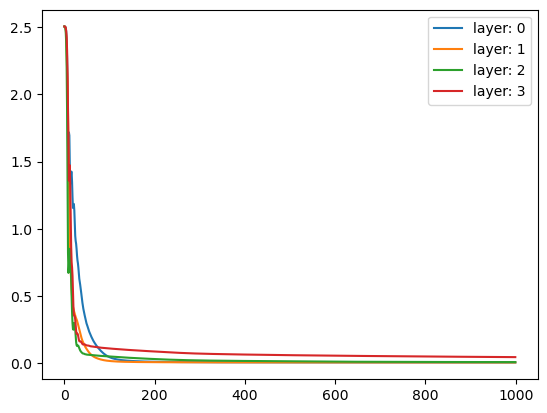

In [347]:
for i,ly in enumerate(ls):
  plt.plot(ls[i], label = 'layer: ' + str(i))
plt.legend(loc="upper right")

In [348]:
print('train acc:', net.predict(x_train).eq(y).float().mean().item())

train acc: 1.0


## Prediction

In [349]:
x_test, Y_actual = next(iter(train_loader))
Y_preds = net.predict(x_test)
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))

Test Accuracy : 1.0


# Baseline - BP

## Dataset

In [350]:
def vectorize_batch(batch, embed_method = 'GloVe'):
    Y, X = list(zip(*batch))
    
    if embed_method == 'GloVe':
      X = [TOKENIZER(x) for x in X]
      X_tensor = torch.zeros(len(batch), 300)
      for i, tokens in enumerate(X):
          X_tensor[i] = GLOVE.get_vecs_by_tokens(tokens).mean(dim=0) ## Averaging Embedding accross all words of text document
    
    if embed_method == 'sbert': #slow
      X_tensor = torch.cat([sbert_mapping[x].unsqueeze(0) for x in X], dim=0)

    return X_tensor, torch.tensor(Y) - 1 

In [351]:
num_train = round(0.95*len(train_dataset))
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_loader = DataLoader(split_train_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
valid_loader = DataLoader(split_valid_, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))
test_loader = DataLoader(test_dataset, batch_size=1024, collate_fn= lambda x : vectorize_batch(x, embed_method=EMBD))

In [352]:
for X, Y in train_loader:
    print(X)
    print(X.shape, Y.shape)
    break

tensor([[ 0.0125,  0.0829,  0.0958,  ..., -0.0590, -0.0161,  0.0346],
        [-0.0847, -0.0032,  0.0161,  ..., -0.0043, -0.0676,  0.0497],
        [-0.0747,  0.0524,  0.0301,  ...,  0.0337, -0.0941,  0.0408],
        ...,
        [ 0.0204, -0.0405,  0.0556,  ..., -0.0080, -0.0901,  0.0015],
        [ 0.0582, -0.0111,  0.0519,  ..., -0.0315, -0.0327,  0.0051],
        [-0.0711,  0.0805,  0.0473,  ...,  0.0098, -0.0608,  0.0558]])
torch.Size([950, 384]) torch.Size([950])


In [353]:
embed_len = X.shape[1]
embed_len

384

## Model

In [354]:
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, NUM_CLASS),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

## Train the model

In [355]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        # print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        # print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        return(torch.tensor(losses).mean(), accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy()))

In [356]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            # X: Batch_size x (25*300)
            # Y: Batch_size x 1
            # Y_preds: Batch_size x num_class
            Y_preds = model(X) 

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(torch.tensor(losses).mean().item())
        train_acc.append(accuracy_score(Y.numpy(), Y_preds.argmax(dim=-1).numpy()))
        ls,ac = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        val_loss.append(ls)
        val_acc.append(ac)

        if i%5==0:
            print("Train Loss : {:.4f}".format(train_loss[-1]))
            print("Train Acc  : {:.4f}".format(train_acc[-1]))
            print("Valid Loss : {:.4f}".format(ls))
            print("Valid Acc  : {:.4f}".format(ac))
            # CalcValLossAndAccuracy(model, loss_fn, val_loader)
    return(train_loss,train_acc,val_loss,val_acc)

In [357]:
epochs = 20
learning_rate = 5*1e-4

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

train_loss,train_acc,val_loss,val_acc = TrainModel(embed_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

100%|██████████| 1/1 [00:00<00:00, 70.73it/s]


Train Loss : 0.6881
Train Acc  : 0.5295
Valid Loss : 0.6773
Valid Acc  : 0.6200


100%|██████████| 1/1 [00:00<00:00, 22.58it/s]


Train Loss : 0.6791
Train Acc  : 0.5295
Valid Loss : 0.6656
Valid Acc  : 0.6200


100%|██████████| 1/1 [00:00<00:00, 73.70it/s]


Train Loss : 0.6617
Train Acc  : 0.5779
Valid Loss : 0.6434
Valid Acc  : 0.7200


100%|██████████| 1/1 [00:00<00:00, 66.08it/s]

Train Loss : 0.6350
Train Acc  : 0.7789
Valid Loss : 0.6099
Valid Acc  : 0.8600


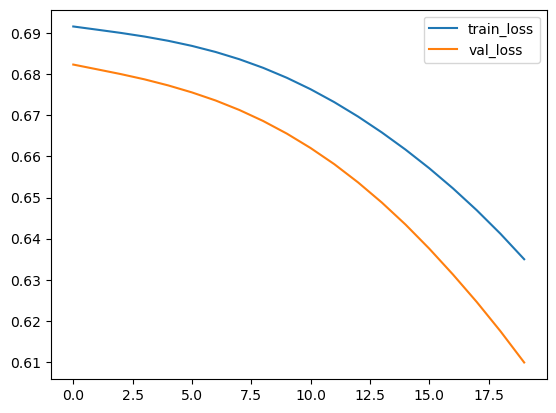

In [358]:
plt.plot(train_loss,label = 'train_loss')
plt.plot(val_loss,label = 'val_loss')
plt.legend(loc="upper right")

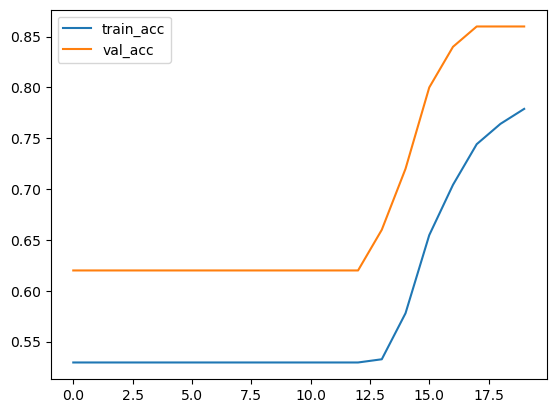

In [359]:
plt.plot(train_acc,label = 'train_acc')
plt.plot(val_acc,label = 'val_acc')
plt.legend(loc="upper left")

## Prediction

In [360]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [361]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))

Test Accuracy : 0.7483333333333333
